# Change detection in water and moisture indices

PAIRS allows to execute arbitrary math operations on data layers via *user defined functions* (UDFs). In this notebook we will use this feature to calculate moisture and water indices from Sentinel 2 data.

The general idea behind these indices is that water reflects less radiation in the infrared range than other land cover. While it is hard to extract moisture content -- or even just the presence of water bodies -- from raw satellite data (whether in the visible part of the optical spectrum or not), these indices allow to obtain such information much more clearly.

Modified Normalized Difference Water Index (mNDWI) is a variant of the NDWI index used to detect water bodies in satellite or aerial images. This index is more effective compared to the NDWI index as it reduces characteristics of built-up areas that often correlate with open water in other indices.The formula for calculating it would be:

$mNDWI = \frac{(Green – SWIR)} {(Green + SWIR)}$

Normalized Difference Moisture Index (NDMI) is used to determine vegetation water content. The formula for calculating it would be:

$NDMI = \frac{(NIR - SWIR)} {(NIR + SWIR)}$

where Green = pixel values from the green band and SWIR = pixel values from the short-wave infrared band and NIR = near-infrared band 

## References for moisture and water indices

There are a number of different water indices. See the following references for additional information see e.g.
- https://en.wikipedia.org/wiki/Normalized_difference_water_index
- McFeeters, S.K. The use of the Normalized Difference Water Index (NDWI) in the delineation of open water
features. Int. J. Remote Sens. 1996, 17, 1425–1432.
- Xu, H. Modification of normalised difference water index (NDWI) to enhance open water features in remotely
sensed imagery. Int. J. Remote Sens. 2006.
- Feyisa, G.L.; Meilby, H.; Fensholt, R.; Proud, S.R. Automated Water Extraction Index: A new technique for
surface water mapping using Landsat imagery. Remote Sens. Environ. 2014, 140, 23–35. 

In the following we will calculate mNDWI, NDMI in a single query.

In [3]:
%matplotlib inline
from datetime import datetime, timedelta
import os, re, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from ibmpairs import query, client
import ibmpairs.authentication as authentication
import ibmpairs.catalog as catalog
import ibmpairs.client as client
import ibmpairs.query as query
import ibmpairs.dashboard as dashboard
import json
import PIL


In [4]:
import configparser
config = configparser.RawConfigParser()
config.read('secrets.ini')

EIS_HOST       = config.get('EIS', 'api.host')
EIS_API_KEY    = config.get('EIS', 'api.key')
EIS_TENANT_ID  = config.get('EIS', 'api.tenant_id') 
EIS_ORG_ID     = config.get('EIS', 'api.org_id')  

p2_credentials  = client.get_client(api_key   = EIS_API_KEY,
                                    tenant_id = EIS_TENANT_ID,
                                    org_id    = EIS_ORG_ID,
                                    legacy    = False
                                   )

2024-06-13 16:42:58 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-06-13 16:42:58 - paw - INFO - Legacy Environment is False
2024-06-13 16:42:58 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-06-13 16:43:01 - paw - INFO - Authentication success.
2024-06-13 16:43:01 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


In [5]:
# Moisture NDWI detection query for 2023-07 and 2020-11
NDWI_queryJson = {'layers': [
  # raw Sentinel 2 Layers  
  {'alias': 'SWIR_1_202304', 'type': 'raster', 'id': '49686', 'temporal': {'intervals': [{'snapshot': '2023-03-05T00:00:00Z'}]}, 'output': False},
  {'alias': 'SWIR_1_202319', 'type': 'raster', 'id': '49686', 'temporal': {'intervals': [{'snapshot': '2023-06-28T00:00:00Z'}]}, 'output': False},
  {'alias': 'NIR_202304',    'type': 'raster', 'id': '49361', 'temporal': {'intervals': [{'snapshot': '2023-03-05T00:00:00Z'}]}, 'output': False},
  {'alias': 'NIR_202319',    'type': 'raster', 'id': '49361', 'temporal': {'intervals': [{'snapshot': '2023-06-28T00:00:00Z'}]}, 'output': False},
  {'alias': 'Green_202304',  'type': 'raster', 'id': '49681', 'temporal': {'intervals': [{'snapshot': '2023-03-05T00:00:00Z'}]}, 'output': False},
  {'alias': 'Green_202319',  'type': 'raster', 'id': '49681', 'temporal': {'intervals': [{'snapshot': '2023-06-28T00:00:00Z'}]}, 'output': False},
  #derivedLayers using a EIS Geospatial leveraging Built-in User Defined functions
  {'alias': 'mNDWI_202304', 'expression': '($Green_202304 - $SWIR_1_202304) / ($Green_202304 + $SWIR_1_202304)'},
  {'alias': 'mNDWI_202319', 'expression': '($Green_202319 - $SWIR_1_202319) / ($Green_202319 + $SWIR_1_202319)'},
  {'alias': 'NDMI_202304',  'expression': '($NIR_202304 - $SWIR_1_202304) / ($NIR_202304 + $SWIR_1_202304)'},
  {'alias': 'NDMI_202319',  'expression': '($NIR_202319 - $SWIR_1_202319) / ($NIR_202319 + $SWIR_1_202319)'}],
  # the Area where fires happened
 'spatial': {'type': 'square', 'coordinates': ['43.775625', '6.091311', '43.803677', '6.150827']},
  # The dates 
 'temporal': {'intervals': [{'snapshot': '2023-04-04T00:00:00Z'}]}
}
print("Query initialised")

Query initialised


In [6]:
# Now, executes the query 
NDWI_query = query.submit_check_status_and_download(NDWI_queryJson)

2024-06-13 16:43:01 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-06-13 16:43:02 - paw - INFO - The query was successfully submitted with the id: 1718236800_40382322.
2024-06-13 16:43:03 - paw - INFO - The query 1718236800_40382322 has the status Queued.
2024-06-13 16:43:34 - paw - INFO - The query 1718236800_40382322 has the status Running.
2024-06-13 16:44:05 - paw - INFO - The query 1718236800_40382322 has the status Running.
2024-06-13 16:44:36 - paw - INFO - The query 1718236800_40382322 has the status Running.
2024-06-13 16:45:07 - paw - INFO - The query 1718236800_40382322 has the status Succeeded.
2024-06-13 16:45:07 - paw - INFO - The query 1718236800_40382322 was successful after checking the status.
2024-06-13 16:45:37 - paw - INFO - The query 1718236800_40382322 has the status Succeeded.
2024-06-13 16:45:37 - paw - INFO - The query 1718236800_40382322 was successful after checking the status.
2024-06-13 16:45:37 - paw - WARNING - The query download fo

In [7]:
def Display_rasters_from_download(rasterfiles_list):
    for f in rasterfiles_list :
        if  f.endswith('.tiff'):
            # read the  json file
            with open(f+'.json', 'r') as ff:
                fileparms = json.load(ff)
            boundingBox=fileparms["boundingBox"]
            myextent=[boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
            # Find layer files to load from downloaded zip.    
            arrayNDMI = np.array(PIL.Image.open(f))
            plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
            if 'NDMI' in f:
                plt.imshow(arrayNDMI,cmap = 'RdYlGn', vmin=-1, vmax=1,extent = myextent) # Loads the raster data and sets the colormap
            else:
                plt.imshow(arrayNDMI,cmap = 'Blues', vmin=-1, vmax=1, extent = myextent)
            plt.colorbar() # Adds the color bar
            plt.title(" "+os.path.basename(f))
    plt.show( ) # Displays the image

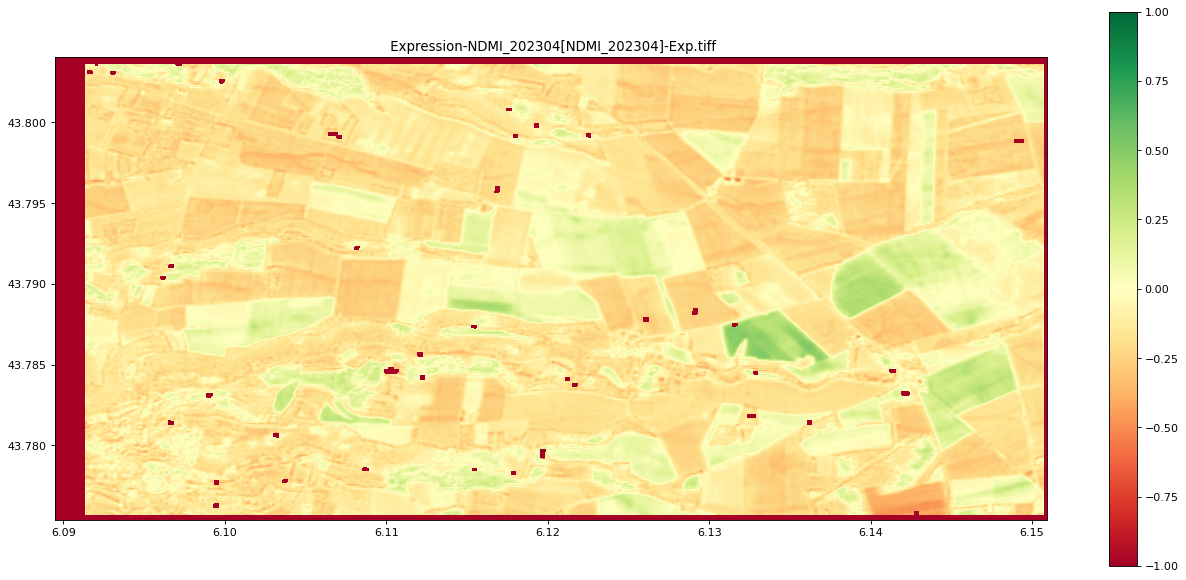

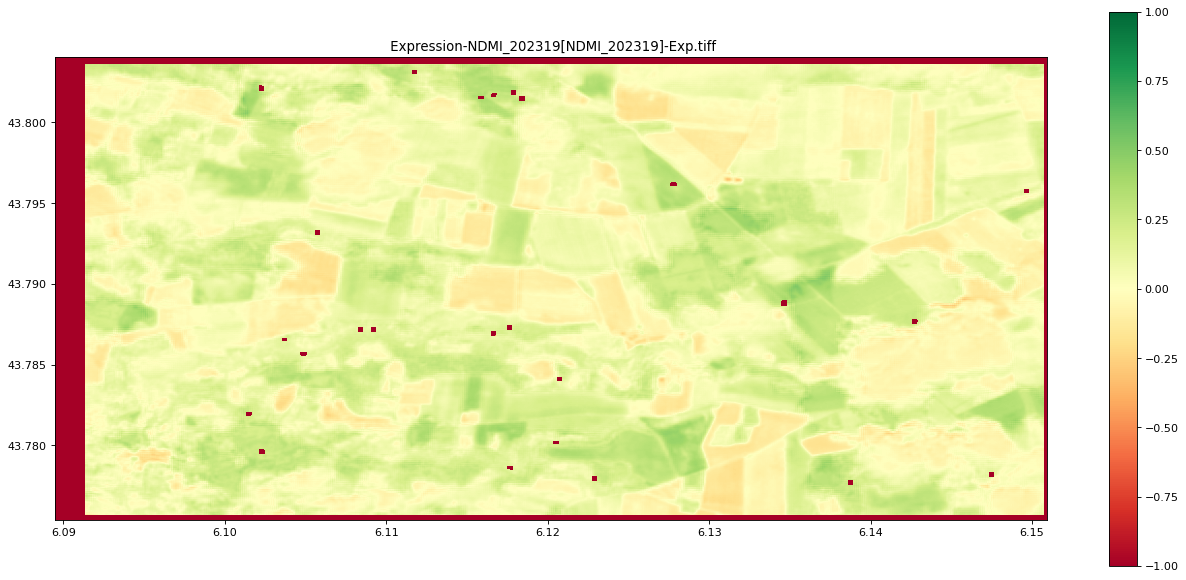

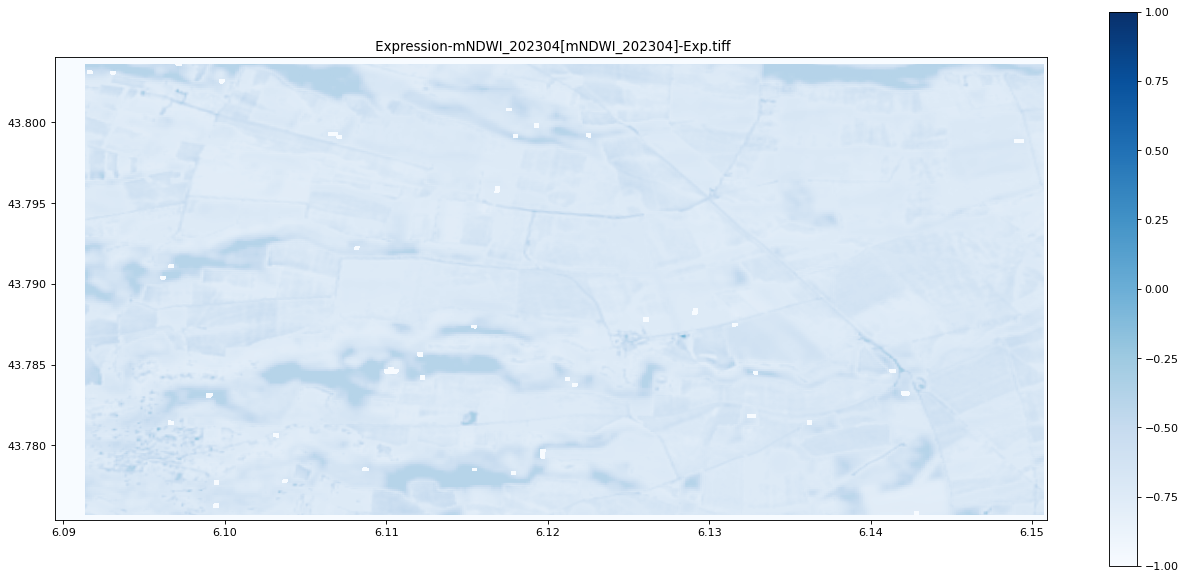

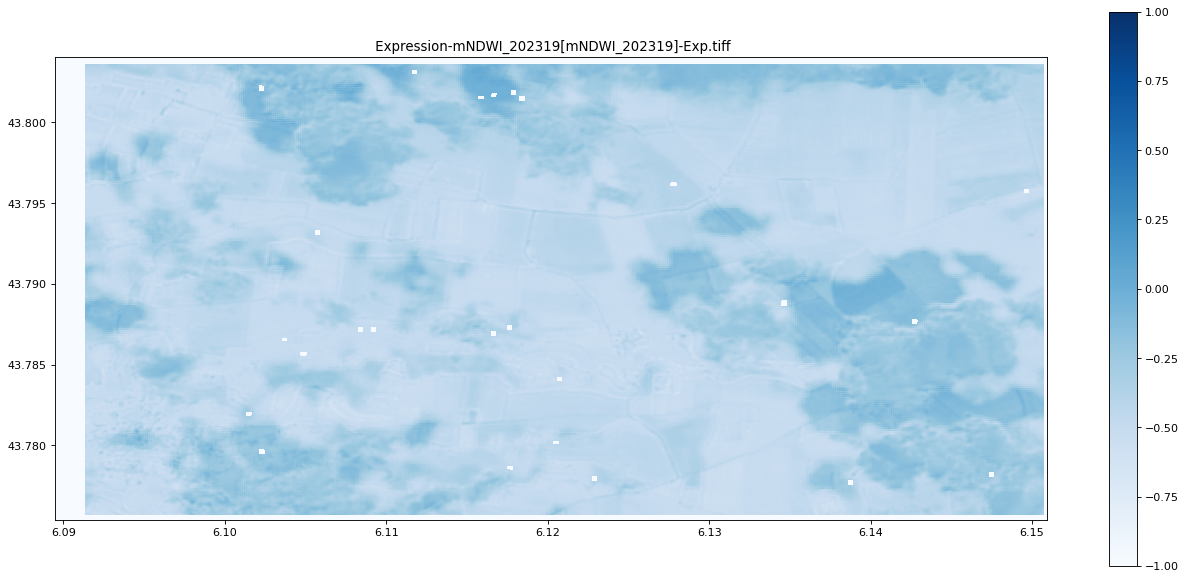

In [8]:
result_rasterfiles_list = NDWI_query.list_files()
result_rasterfiles_list.sort()
Display_rasters_from_download(result_rasterfiles_list)

In [9]:
def get_extent(f):
    with open(f, 'r') as ff:
        stats = json.load(ff)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent

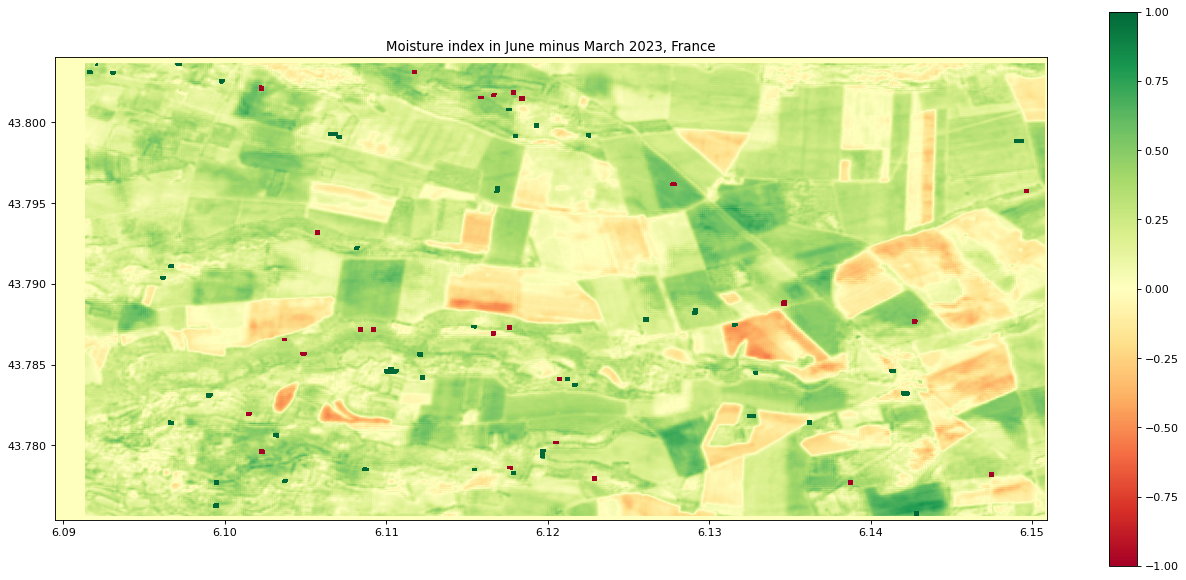

In [10]:
for f in result_rasterfiles_list :
       if (("NDMI_202304") in f)&(f.endswith("tiff")):
          arrayNDMI_Jul=np.array(PIL.Image.open(f))
          arrayNDMI_Jul_extent= get_extent(f+'.json')
       elif (("NDMI_202319") in f)&(f.endswith("tiff")):
          arrayNDMI_Nov=np.array(PIL.Image.open(f))
plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
plt.imshow(arrayNDMI_Nov-arrayNDMI_Jul,cmap = 'RdYlGn', vmin=-1, vmax=1,extent=arrayNDMI_Jul_extent) # Loads the raster data and sets the colormap
plt.colorbar() # Adds the color bar
plt.title("Moisture index in June minus March 2023, France")
plt.show( ) # Displays the image
    